In [77]:
from typing import List, Tuple
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import cv2
import pytesseract
import matplotlib.pyplot as plt
import os
from PIL import Image

import easyocr
reader = easyocr.Reader(["en"])

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

# Segment function updated to use the trained model for character recognition
def segment(
			source: List[List[Image.Image]]
	) -> Tuple[List[List[List[Image.Image]]], List[List[List[Image.Image]]], List[List[List[Tuple[Image.Image, str]]]]]:
	"""
	Segment the license plates into individual characters and visualize bounding boxes.

	:param source: Output of the extract_boxes function
	:return: Segments of license plates, visualizations of detected bounding boxes before and after filtering, and final segments with recognized characters.
	"""
	segments = []
	visualizations = []
	recognized_characters = []
	yolo_bounding_boxes = []

	for img in source:
		img_segments = []
		img_visualizations = []
		img_recognized = []
		img_yolo_boxes = []
		for plate in img:
			plate_segments = []
			plate_visualizations = []
			plate_recognized = []
			plate_yolo_boxes = [] # List to store the bounding boxes for this plate
			
			# Resize the plate to a consistent size
			plate = plate.resize((200, 50))
			image_width,image_height = plate.size
			
			# Convert to grayscale if not already
			if plate.mode != "L":
				gray = plate.convert("L")
			else:
				gray = plate.copy()
			gray = np.array(gray)
			
			# Preprocess using adaptive thresholding
			blurred = cv2.GaussianBlur(gray, (5, 5), 0)
			thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
			
			# Invert the thresholded image to ensure white text on black background
			thresh = cv2.bitwise_not(thresh)
			
			# Find contours
			contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
			hierarchy = hierarchy[0]
			
			# Create an initial visualization with all bounding boxes
			original_visualization = plate.convert("RGB")
			draw = ImageDraw.Draw(original_visualization)
			for contour in contours:
				x, y, w, h = cv2.boundingRect(contour)
				draw.rectangle([x, y, x + w, y + h], outline="red", width=1)
			plate_visualizations.append(original_visualization)
			
			# Filter contours to remove obvious noise, but retain characters and possible extra regions
			bounding_boxes = []
			for i, contour in enumerate(contours):
				x, y, w, h = cv2.boundingRect(contour)
				aspect_ratio = w / float(h)
				area = w * h
				parent_idx = hierarchy[i][3]
				child_idx = hierarchy[i][2]
				
				# Use relative area to filter contours after resizing plate to a consistent size
				if 0.1 < aspect_ratio < 2.0 and 70 < area < 800:
					# Check if the contour is not a hole (i.e., not a child of another character)
					# and if it has no children or its children are significantly smaller
					is_valid_character = True
					if parent_idx != -1:
						# If this contour is a child, it might be a hole, so skip it
						continue
					if child_idx != -1:
						# Iterate over all children and check their area
						while child_idx != -1:
							child_area = cv2.contourArea(contours[child_idx])
							if child_area > 0.5 * area:
								# If the child area is significant, this means it might not be a hole
								is_valid_character = False
								break
							child_idx = hierarchy[child_idx][0]  # Get the next child
					
					if is_valid_character:
						bounding_boxes.append((x, y, w, h))
			
			# Create a visualization after initial filtering
			filtered_visualization = plate.convert("RGB")
			draw = ImageDraw.Draw(filtered_visualization)
			for x, y, w, h in bounding_boxes:
				draw.rectangle([x, y, x + w, y + h], outline="green", width=1)
			plate_visualizations.append(filtered_visualization)
			
			# Sort from left to right
			bounding_boxes = sorted(bounding_boxes, key=lambda box: box[0])

			
			# Step 2: Apply the trained model to recognize characters in each segment
			for x, y, w, h in bounding_boxes:
				# YOLO format
				x_center = (x + w/2) / image_width
				y_center = (y + h/2) / image_height
				width_normalized = w / image_width
				height_normalized = h / image_height
				class_id = 0
				plate_yolo_boxes.append((class_id, x_center, y_center, width_normalized, height_normalized))

				#-------------------------------------- 
				segment = plate.crop((x, y, x + w, y + h))
				r = w / h
				new_w, new_h = 60, 80
				segment = segment.resize((new_w-20, new_h-20))
				segment_orig = np.array(segment)
				segment = segment.convert("L")

				# binarialize the image
				before = segment.copy()
				_, segment = cv2.threshold(np.array(segment), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
				segment = Image.fromarray(segment)

				# place the segment on a black background slightly larger than the original
				background = Image.new('L', (new_w, new_h), 255)
				offset = (10, 10)
				background.paste(segment, offset)
				segment = background     

				# Predict with tessaract
				# ocr_result = pytesseract.image_to_data(
				# 	segment,
				# 	config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ',
				# 	output_type=pytesseract.Output.DICT
				# )
				# Predict with easyocr
				ocr_result = reader.recognize(
					np.array(segment),
					allowlist="0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
				)
				ocr_result = {
					"text": [res[1] for res in ocr_result],
					"conf": [res[2]*100 for res in ocr_result]
				}
				
				# Filter based on confidence
				# try:
				# 	ocr_result['conf'][0]
				# except:
					# plt.imshow(segment)
					# plt.show()
				confidences = [float(conf) for conf in ocr_result['conf']]
				
				# Filter blue segments (E parts)
				segment_orig = cv2.cvtColor(segment_orig, cv2.COLOR_RGB2HSV)
				lower_blue = np.array([100, 50, 50])
				upper_blue = np.array([140, 255, 255])
				blue_mask = cv2.inRange(segment_orig, lower_blue, upper_blue)
				blue_pixel_count = cv2.countNonZero(blue_mask)
				total_pixel_count = segment_orig.shape[0] * segment_orig.shape[1]
				blue_ratio = blue_pixel_count / total_pixel_count	
				
				is_blue = blue_ratio > 0.01
	
				# Filter blobs
				eroded = 255 - np.array(segment)
				eroded = cv2.erode(eroded, np.ones((3, 3)), iterations=8)
				is_blob = np.count_nonzero(eroded) / (new_w*new_h) > 0.05

				if confidences and max(confidences) >= -1 and not is_blue and not is_blob:
					recognized_text = ocr_result['text'][np.argmax(confidences)].strip()
					plate_segments.append(segment)
					plate_recognized.append((segment, recognized_text, max(confidences), ocr_result, before))
			
			
			img_segments.append(plate_segments)
			img_visualizations.append(plate_visualizations)
			img_recognized.append(plate_recognized)
			img_yolo_boxes.append(plate_yolo_boxes)  # Add plate bounding boxes to image list

		segments.append(img_segments)
		visualizations.append(img_visualizations)
		recognized_characters.append(img_recognized)
		yolo_bounding_boxes.append(img_yolo_boxes)  # Add image bounding boxes to main list

	return segments, visualizations, recognized_characters,yolo_bounding_boxes


# Visualization script for debugging
def visualize_bounding_boxes(visualizations: List[List[List[Image.Image]]]):
	for img_vis in visualizations:
		for plate_vis in img_vis:
			for vis in plate_vis:
				plt.imshow(vis)
				plt.show()

In [78]:
path_crops = "C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/SegmentationTestImages/images"
images = []

for filename in os.listdir(path_crops):
    if filename.endswith(('.jpg', '.jpeg')): 
        file_path = os.path.join(path_crops, filename)
        img = Image.open(file_path)  
        images.append([img]) 

[[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=846x210 at 0x21EE8BF5B70>], [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=453x155 at 0x21EE8BF67D0>], [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=862x231 at 0x21EE8BF51E0>], [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=667x221 at 0x21EE8BF7A90>], [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1238x398 at 0x21EE8BF7670>], [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1163x358 at 0x21EF40AC220>], [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=841x268 at 0x21EF40AF070>], [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=759x190 at 0x21EF40AECB0>], [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1236x402 at 0x21EF40AEC50>], [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=589x122 at 0x21EF40AF130>]]


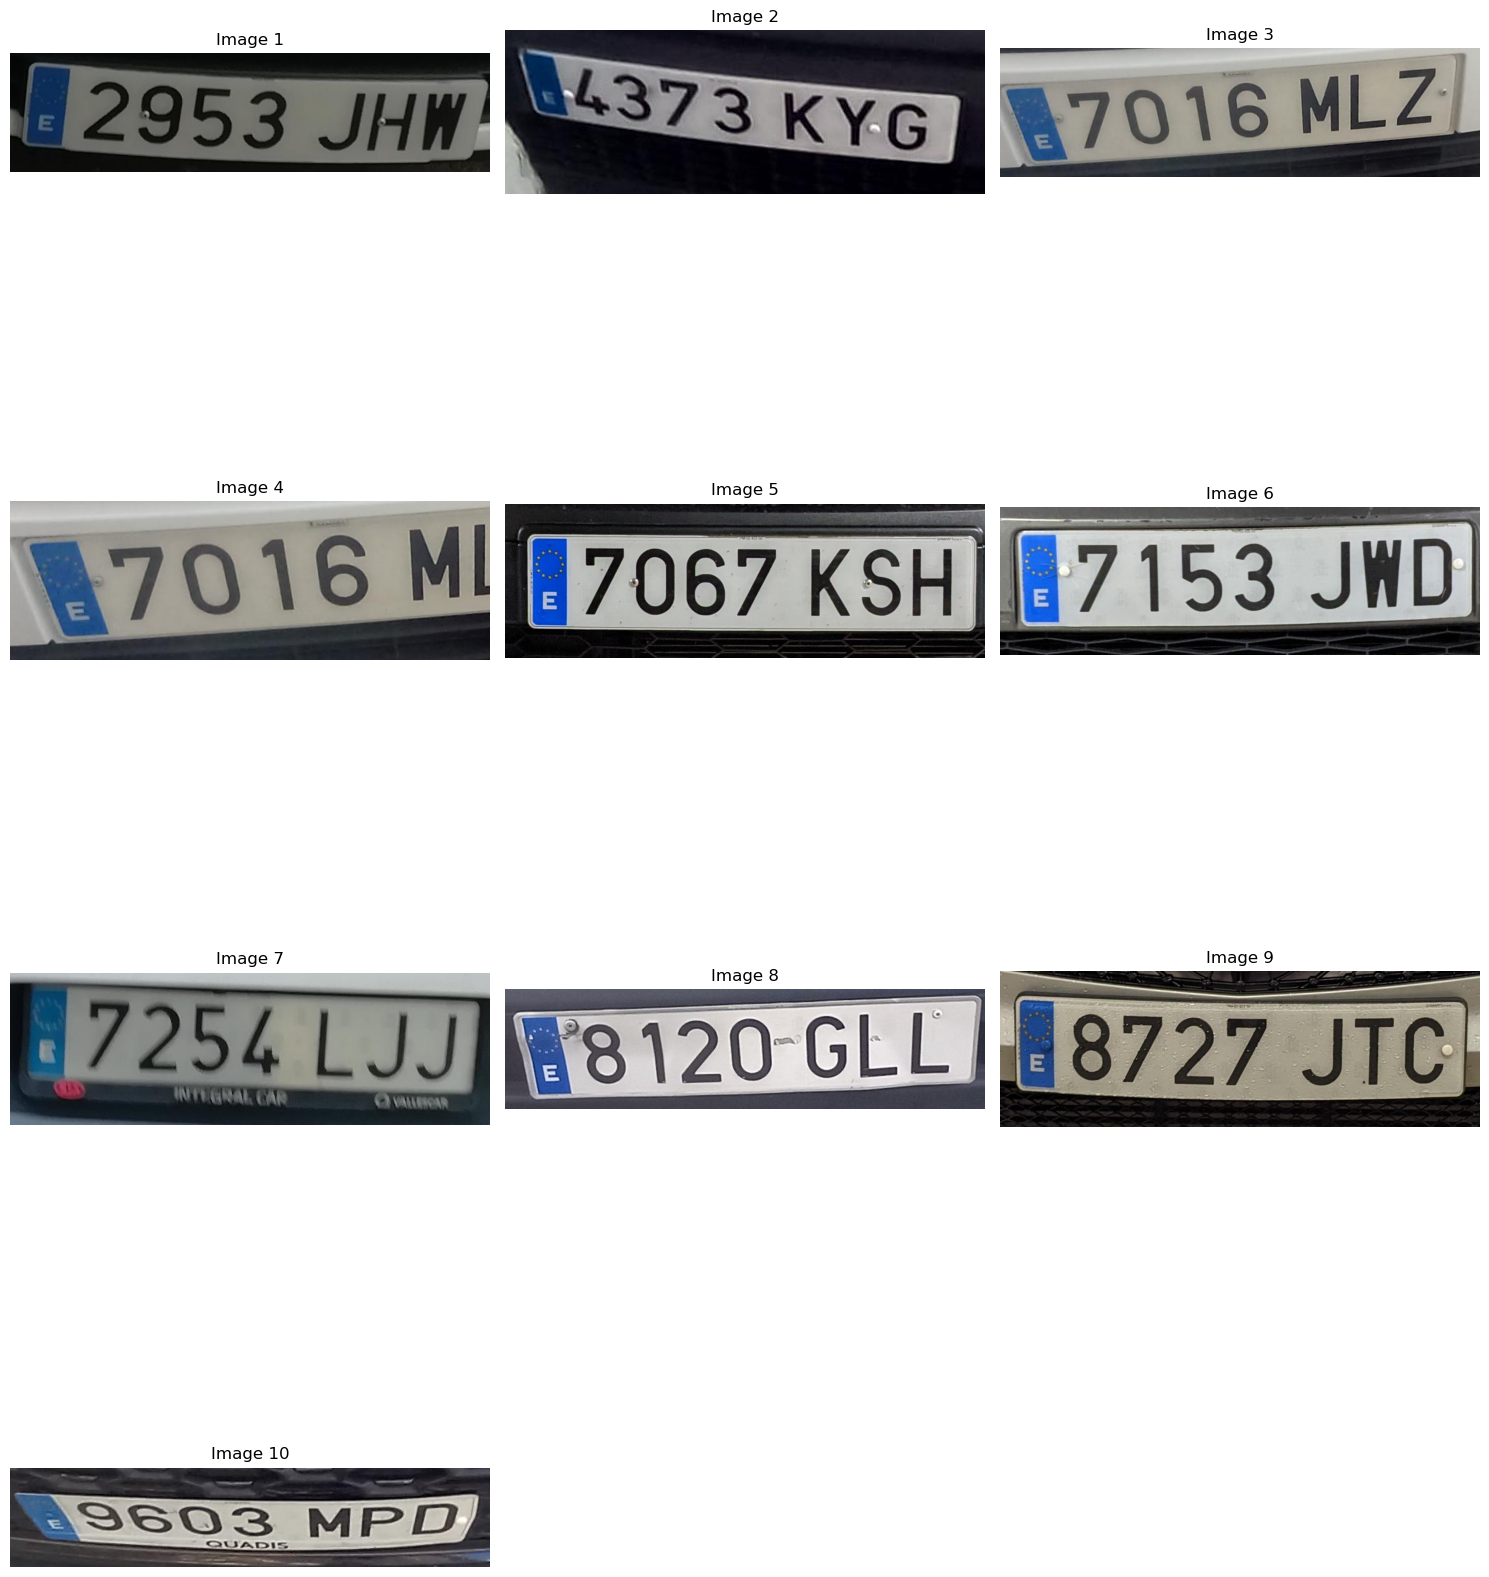

In [79]:
print(images)
# Create a figure for displaying images
num_images = len(images)
cols = 3  # Number of columns for layout
rows = (num_images // cols) + (num_images % cols > 0)  # Calculate rows needed

plt.figure(figsize=(15, 5 * rows))  # Adjust figure size based on number of rows

for index, image_list in enumerate(images):
    image = image_list[0]  # Access the actual image from the nested list
    plt.subplot(rows, cols, index + 1)  # Create subplot
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f'Image {index + 1}')  # Title for each image

# Show the plot with all images
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

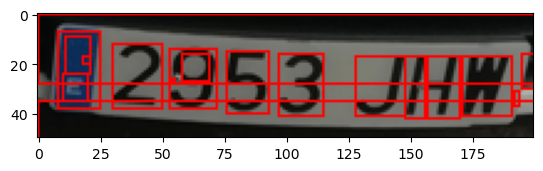

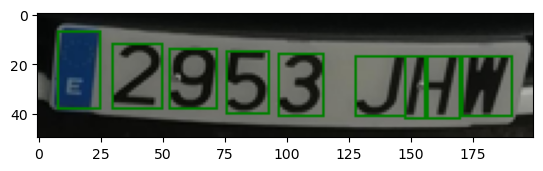

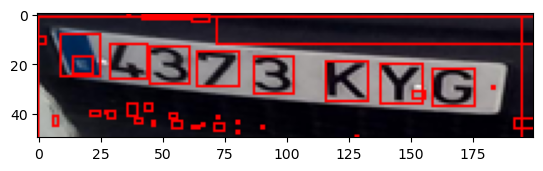

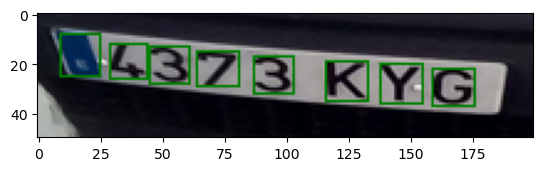

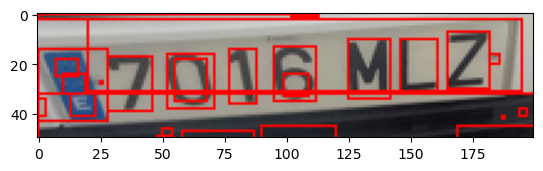

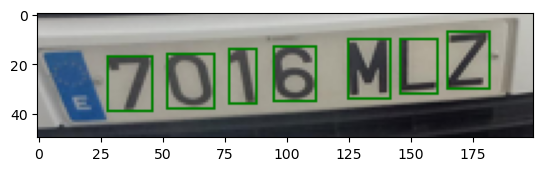

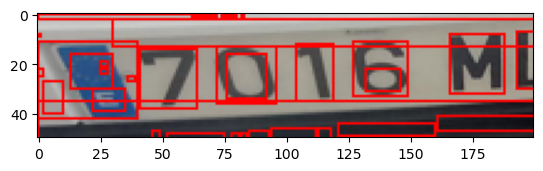

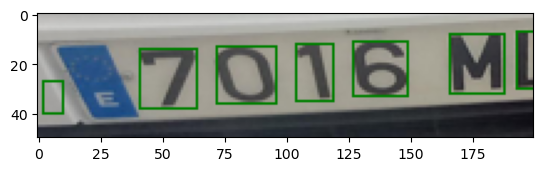

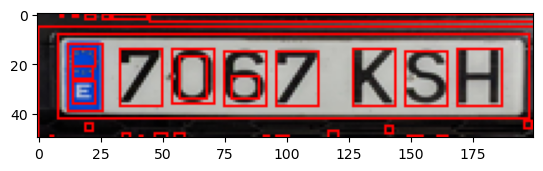

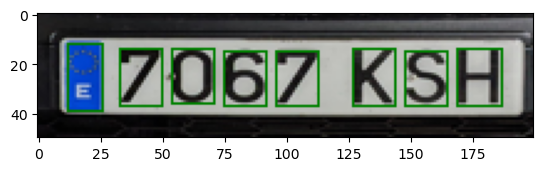

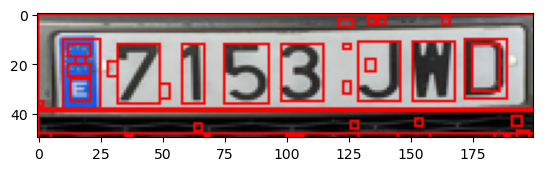

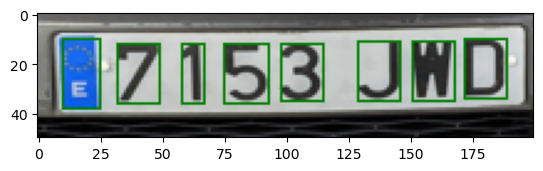

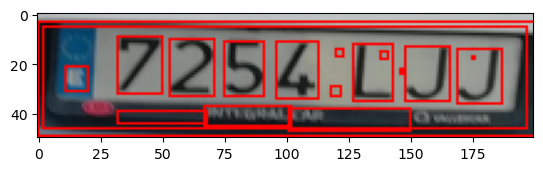

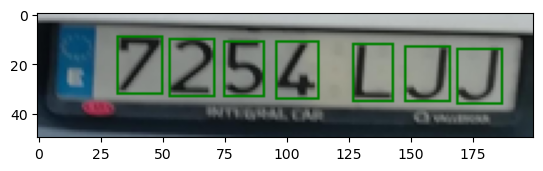

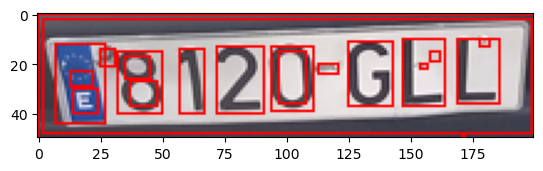

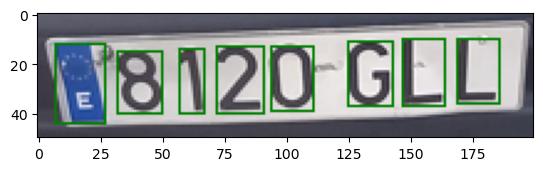

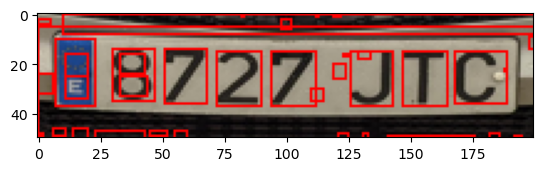

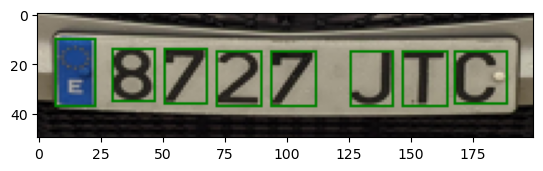

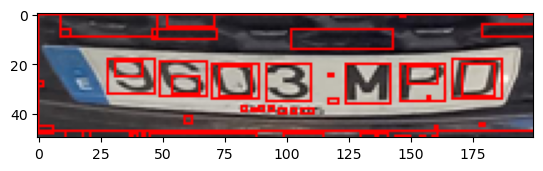

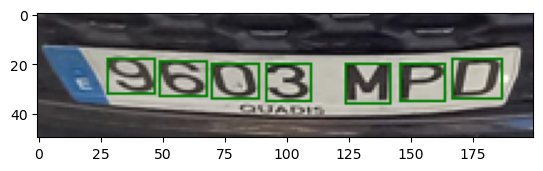

In [80]:
segments, visualizations, recognized_characters, yolo_bounding_boxes  = segment(images)
visualize_bounding_boxes(visualizations)

In [82]:
def read_ground_truth_annotations(annotation_folder: str, image_filenames: List[str]) -> dict[str, List[Tuple[int, float, float, float, float]]]:
    """
    Read  YOLO annotations

    :param annotation_folder
    :param image_filenames: 
    :return: dictionary with the result of each image
    """
    gt_annotations = {}
    for image_filename in image_filenames:
        base_name = os.path.splitext(image_filename)[0]
        annotation_file = os.path.join(annotation_folder, f"{base_name}.txt")
        annotations = []
        if os.path.exists(annotation_file):
            with open(annotation_file, 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        x_center = float(parts[1])
                        y_center = float(parts[2])
                        width = float(parts[3])
                        height = float(parts[4])
                        annotations.append((class_id, x_center, y_center, width, height))
        gt_annotations[image_filename] = annotations
    return gt_annotations

# Convertir de formato YOLO a coordenadas (xmin, ymin, xmax, ymax)
def yolo2corners(box):
    """
    :param: box in YOLO format (x_center, y_center, width, height )
    :return: box in format (xmin, ymin, xmax, ymax)
    """
    x_center, y_center, width, height = box
    xmin = x_center - width / 2
    ymin = y_center - height / 2
    xmax = x_center + width / 2
    ymax = y_center + height / 2
    return xmin, ymin, xmax, ymax

def calculate_iou(box1, box2):
    """
    Compute IOU

    :param box1: Tuple (x_center, y_center, width, height)
    :param box2: Tuple (x_center, y_center, width, height)
    :return: Valor de IoU
    """

    xmin1, ymin1, xmax1, ymax1 = yolo2corners(box1)
    xmin2, ymin2, xmax2, ymax2 = yolo2corners(box2)

    inter_xmin = max(xmin1, xmin2)
    inter_ymin = max(ymin1, ymin2)
    inter_xmax = min(xmax1, xmax2)
    inter_ymax = min(ymax1, ymax2)

    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)

    # Calcular las áreas de las boxes
    area1 = (xmax1 - xmin1) * (ymax1 - ymin1)
    area2 = (xmax2 - xmin2) * (ymax2 - ymin2)

    # Calcular IoU
    iou = inter_area / (area1 + area2 - inter_area) if (area1 + area2 - inter_area) != 0 else 0

    return iou

def evaluate_predictions(predictions: dict[str, List[Tuple[int, float, float, float, float]]],
                         ground_truths: dict[str, List[Tuple[int, float, float, float, float]]],
                         iou_threshold: float = 0.5):
    """
    Comparison with GroundTruth

    :param predictions: dictionary with the predictions of each img
    :param ground_truths: dictionary with the ground truth of each img
    :param iou_threshold: threshold that determine if is it correct or not
    :return: metrics
    """
    total_gt = 0
    total_pred = 0
    true_positives = 0
    false_positives = 0

    for image_filename in ground_truths:
        gt_boxes = ground_truths.get(image_filename, [])
        pred_boxes = predictions.get(image_filename, [])

        matched_gt = []
        matched_pred = []

        total_gt += len(gt_boxes)
        total_pred += len(pred_boxes)

        for pred_box in pred_boxes:
            best_iou = 0
            best_gt_idx = -1
            for idx, gt_box in enumerate(gt_boxes):
                if idx in matched_gt:
                    continue
                iou = calculate_iou(pred_box[1:], gt_box[1:])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx
            if best_iou >= iou_threshold:
                true_positives += 1
                matched_gt.append(best_gt_idx)
                matched_pred.append(pred_box)
            else:
                false_positives += 1

    false_negatives = total_gt - true_positives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / total_gt if total_gt > 0 else 0

    metrics = {
        'total_ground_truth': total_gt,
        'total_predictions': total_pred,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'precision': precision,
        'recall': recall
    }

    return metrics

import matplotlib.patches as patches

def visualize_predictions(image_folder: str,
                          image_filenames: List[str],
                          ground_truths: dict[str, List[Tuple[int, float, float, float, float]]],
                          predictions: dict[str, List[Tuple[int, float, float, float, float]]]):
    """
    Visualiza las bounding boxes del ground truth y las predicciones en las imágenes.

    :param image_folder: 
    :param image_filenames:
    :param ground_truths:
    :param predictions: 
    """
    for image_filename in image_filenames:
        image_path = os.path.join(image_folder, image_filename)
        image = Image.open(image_path)
        image_width, image_height = image.size

        gt_boxes = ground_truths.get(image_filename, [])
        pred_boxes = predictions.get(image_filename, [])

        fig, ax = plt.subplots(1)
        ax.imshow(image)

        # Dibujar bounding boxes del ground truth en verde
        for gt_box in gt_boxes:
            class_id, x_center, y_center, width, height = gt_box
            x_center *= image_width
            y_center *= image_height
            width *= image_width
            height *= image_height
            xmin = x_center - width / 2
            ymin = y_center - height / 2
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

        # Dibujar bounding boxes de las predicciones en rojo
        for pred_box in pred_boxes:
            class_id, x_center, y_center, width, height = pred_box
            x_center *= image_width
            y_center *= image_height
            width *= image_width
            height *= image_height
            xmin = x_center - width / 2
            ymin = y_center - height / 2
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        plt.title(f"Ground Truth (Green) vs Predicciones (Red) - {image_filename}")
        plt.show()


Evaluation Metrics
total_ground_truth: 70
total_predictions: 77
true_positives: 69
false_positives: 8
false_negatives: 1
precision: 0.8961038961038961
recall: 0.9857142857142858


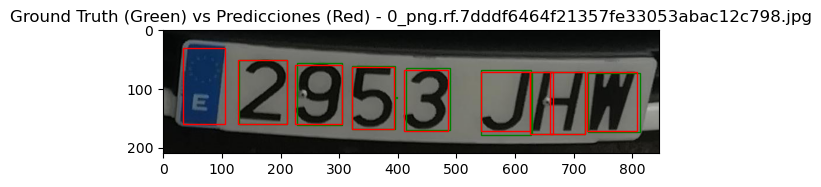

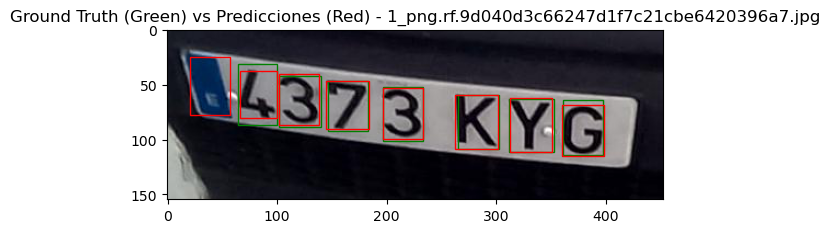

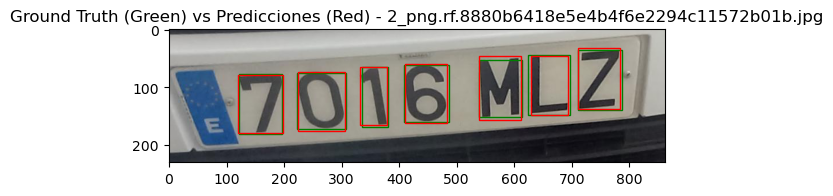

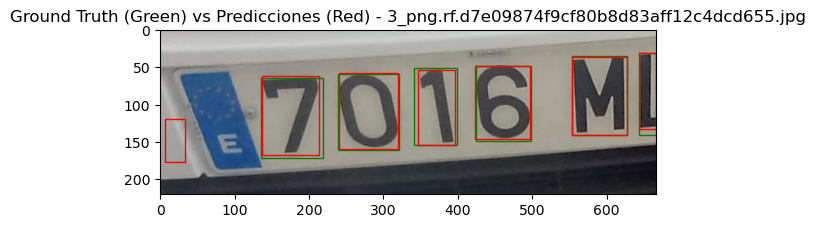

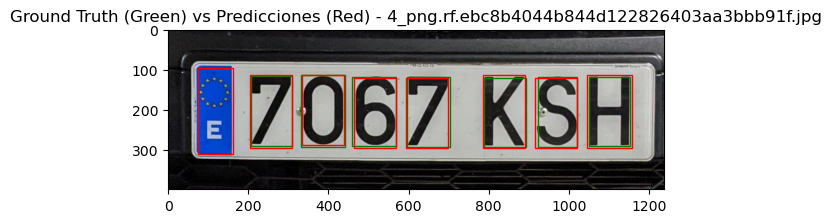

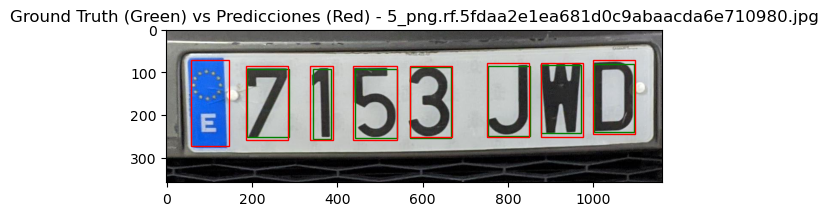

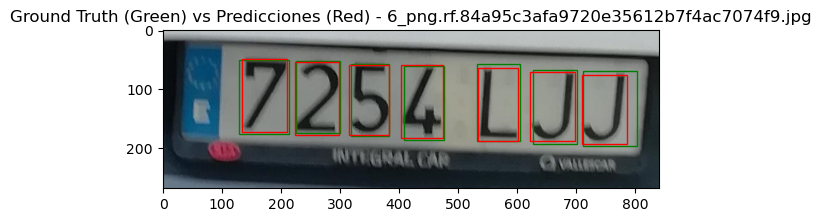

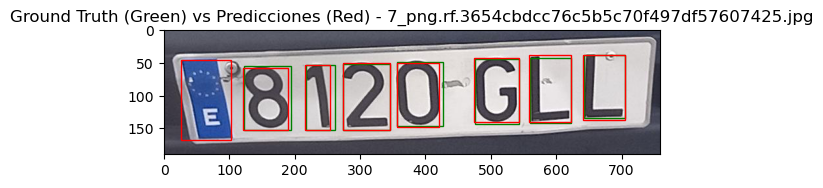

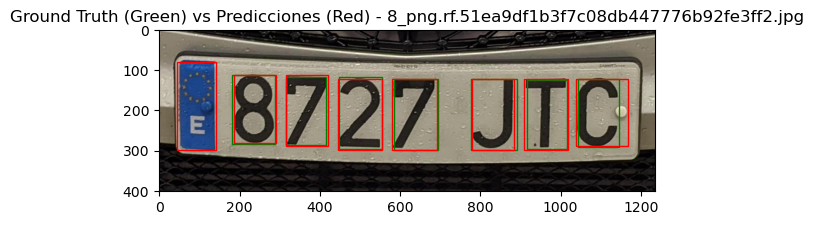

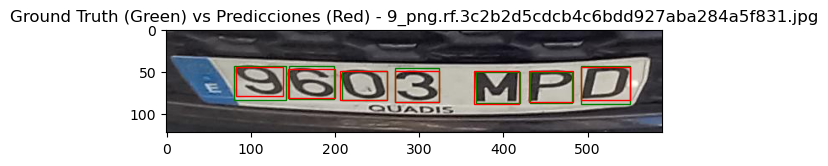

In [83]:

image_folder = 'C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/SegmentationTestImages/images'
annotation_folder = 'C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/SegmentationTestImages/labels'
image_filenames = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

ground_truths = read_ground_truth_annotations(annotation_folder, image_filenames)

# Crear un diccionario de predicciones para cada imagen
predictions = {}
for idx, image_filename in enumerate(image_filenames):
    # yolo_bounding_boxes es una lista de listas (imágenes -> placas -> bounding boxes)
    image_predictions = []
    # Recorremos las placas en la imagen
    for plate_boxes in yolo_bounding_boxes[idx]:
        # Añadimos todas las bounding boxes de la placa
        image_predictions.extend(plate_boxes)
    predictions[image_filename] = image_predictions


metrics = evaluate_predictions(predictions, ground_truths)
print("Evaluation Metrics")
for key, value in metrics.items():
    print(f"{key}: {value}")


visualize_predictions(image_folder, image_filenames, ground_truths, predictions)